# MSDs JAX-MD vs LAMMPS

In [1]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

os.environ['JAX_PLATFORM_NAME'] = "cpu"
os.environ['JAX_PLATFORMS'] = "cpu"

In [2]:
import numpy as np

import matplotlib.pyplot as plt

from helpers import bridge

from MDAnalysis.analysis import rdf
import MDAnalysis as mda

import pandas as pd

/home/florian/anaconda3/envs/jaxidp/lib/python3.11/site-packages/google/colab/data_table.py:30: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets


In [3]:
import matplotlib
from matplotlib.ticker import FormatStrFormatter

plt.rcParams['text.usetex'] = True
matplotlib.rcParams['figure.dpi'] = 200
plt.rc('text.latex', preamble="\\usepackage{siunitx}")

### Load JAX-MD data

This assumes that the notebook [run_simulation.ipynb](./run_simulation.ipynb) has already been executed.

In [4]:
O_TYPE = "1"
H_TYPE = "2"

jaxmd_bridge = bridge.MDABridge.from_file("../data/demo_simulation/dump.npz")
jaxmd_universe = jaxmd_bridge.universe

jaxmd_times = [ts.time for ts in jaxmd_universe.trajectory]

print(jaxmd_times)

print(f"JAX-MD: Universe with {len(jaxmd_universe.atoms)} atoms and {jaxmd_universe.trajectory.n_frames} snapshots over {jaxmd_times[-1]}ps.")

[0.0, 0.288, 0.576, 0.8639999999999999, 1.152, 1.44, 1.7279999999999998, 2.016, 2.304, 2.5919999999999996, 2.88, 3.1679999999999997, 3.4559999999999995, 3.7439999999999998, 4.032, 4.319999999999999, 4.608, 4.896, 5.183999999999999, 5.4719999999999995, 5.76, 6.047999999999999, 6.335999999999999, 6.624, 6.911999999999999, 7.199999999999999, 7.4879999999999995, 7.776, 8.064, 8.351999999999999, 8.639999999999999, 8.927999999999999, 9.216, 9.504, 9.792, 10.08, 10.367999999999999, 10.655999999999999, 10.943999999999999, 11.232, 11.52, 11.808, 12.095999999999998, 12.383999999999999, 12.671999999999999, 12.959999999999999, 13.248, 13.536, 13.823999999999998, 14.111999999999998, 14.399999999999999, 14.687999999999999, 14.975999999999999, 15.264, 15.552, 15.839999999999998, 16.128, 16.416, 16.703999999999997, 16.991999999999997, 17.279999999999998, 17.567999999999998, 17.855999999999998, 18.144, 18.432, 18.72, 19.008, 19.296, 19.584, 19.872, 20.16, 20.447999999999997, 20.735999999999997, 21.0239

In [5]:
def get_rdf(universe: mda.Universe, atom_type_1: str, atom_type_2: str):
    a1 = universe.select_atoms(f'type {atom_type_1}')
    a2 = universe.select_atoms(f'type {atom_type_2}')

    irdf = rdf.InterRDF(a1, a2, nbins=400, range=(0, 10))
    irdf.run()

    x, y = irdf.results.bins, irdf.results.rdf

    return x[1:], np.clip(y, -3, 10)[1:]

In [6]:
rdf_hh_x, rdf_hh_y = get_rdf(jaxmd_universe, H_TYPE, H_TYPE)
rdf_ho_x, rdf_ho_y = get_rdf(jaxmd_universe, O_TYPE, H_TYPE)
rdf_oo_x, rdf_oo_y = get_rdf(jaxmd_universe, O_TYPE, O_TYPE)

# Load reference data

In [7]:
import pandas as pd
hh_reference = pd.read_csv("../data/veronika_daten/piko_TIP3P_rigid_HH_1.dat", delim_whitespace=True, header=0)
oo_reference = pd.read_csv("../data/veronika_daten/piko_TIP3P_rigid_OO_1.dat", delim_whitespace=True, header=0)
oh_reference = pd.read_csv("../data/veronika_daten/piko_TIP3P_rigid_OH_1.dat", delim_whitespace=True, header=0)

/tmp/ipykernel_26642/1388268694.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  hh_reference = pd.read_csv("../data/veronika_daten/piko_TIP3P_rigid_HH_1.dat", delim_whitespace=True, header=0)
/tmp/ipykernel_26642/1388268694.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  oo_reference = pd.read_csv("../data/veronika_daten/piko_TIP3P_rigid_OO_1.dat", delim_whitespace=True, header=0)
/tmp/ipykernel_26642/1388268694.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  oh_reference = pd.read_csv("../data/veronika_daten/piko_TIP3P_rigid_OH_1.dat", delim_whitespace=True, header=0)


# Plot

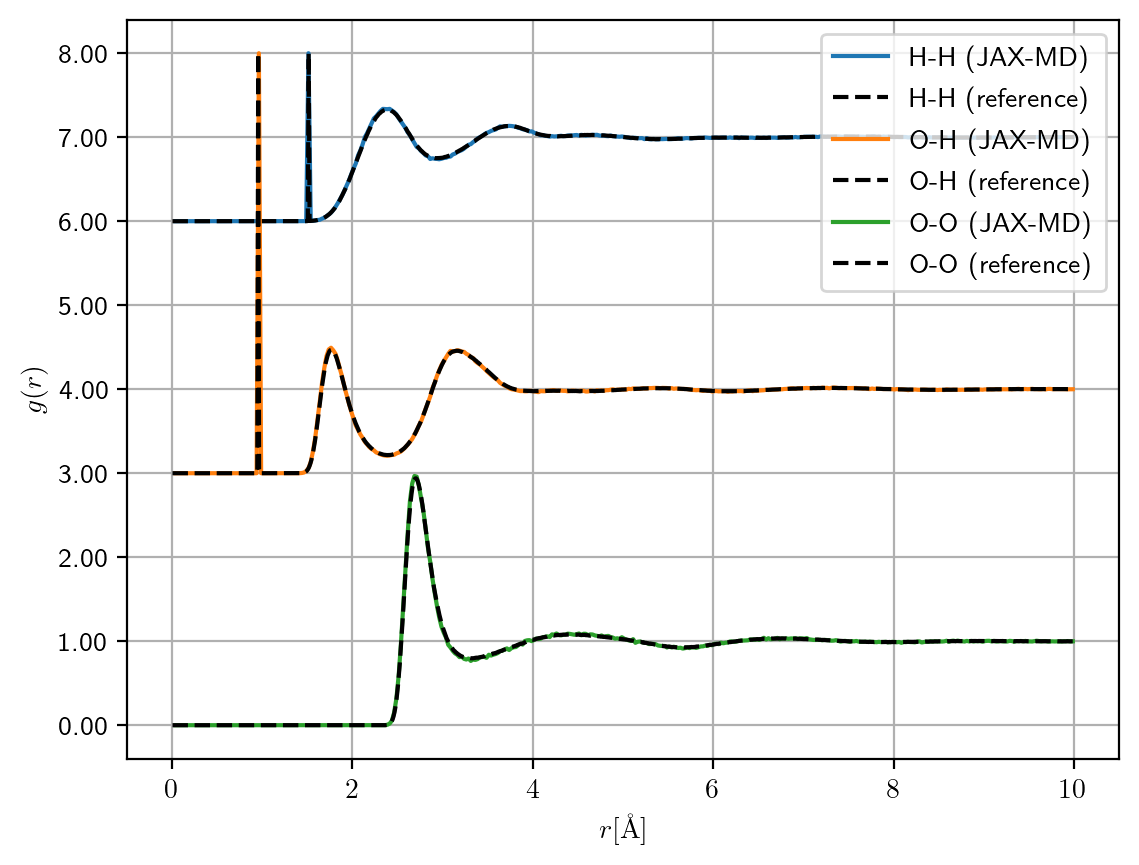

In [8]:
fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.plot(rdf_hh_x, np.clip(rdf_hh_y, 0, 2) + 6, label="H-H (JAX-MD)")
plt.plot(hh_reference["r"], np.clip(hh_reference["g_r"], 0, 2) + 6, label="H-H (reference)", linestyle="dashed", c="black")


plt.plot(rdf_ho_x, np.clip(rdf_ho_y, 0, 5) + 3, label="O-H (JAX-MD)")
plt.plot(oh_reference["r"], np.clip(oh_reference["g_r"], 0, 5) + 3, label="O-H (reference)", linestyle="dashed", c="black")


plt.plot(rdf_oo_x, np.clip(rdf_oo_y, 0, 8) + 0, label="O-O (JAX-MD)")
plt.plot(oo_reference["r"], np.clip(oo_reference["g_r"], 0, 8), label="O-O (reference)", linestyle="dashed", c="black")


plt.legend(loc="upper right")
plt.grid()

ax.set_xlabel("$r [\\unit{\\angstrom}]$")
ax.set_ylabel("$g(r)$")

plt.show()